<a href="https://colab.research.google.com/github/AireesRondain/Call-Transcript/blob/main/FB_GOOG_transcripts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import needed libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks


In [ ]:
import sys
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import pandas as pd
import numpy as np
import re
from pathlib import Path
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import timedelta

%matplotlib inline

Download the spacy mode (small size)

In [ ]:
!{sys.executable} -m spacy download en_core_web_sm
spacy_model = 'en_core_web_sm'

     |████████████████████████████████| 12.0 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


Create spacy model object

In [ ]:
nlp = spacy.load(spacy_model)

Create pandas dataframe

In [ ]:
columns = ['ticker','qtr','year','url']
data = [
      ['FB','Q2',2021,'https://www.fool.com/earnings/call-transcripts/2021/07/29/facebook-fb-q2-2021-earnings-call-transcript/'],
      ['GOOG','Q2',2021,'https://www.fool.com/earnings/call-transcripts/2021/07/27/alphabet-inc-googl-q2-2021-earnings-call-transcrip/']
      ]
df = pd.DataFrame(data=data, columns=columns)
download_dir = Path("./downloads")

**Extract the date of the earnings call transcripts**
then add this call_date as a new column in the dataframe

In [ ]:
df['call_date'] = df['url'].apply(lambda x : pd.to_datetime(re.match(r".*(\d{4}/\d{2}/\d{2})", x).group(1)))

In [ ]:
def download_transcripts(df_row):
  local_path = download_dir / Path(df_row['ticker'] + '-' + df_row['qtr'] + '-' + str(df_row['year']) + '.html')
  if local_path.is_file():
    print(f"File Exists {local_path}")
  else:
    print(f"Downloading {df_row['ticker']}, url: {df_row['url']}")
    url_get = requests.get(df_row['url'])
    soup = BeautifulSoup(url_get.text)
    with open(local_path,'w') as fh:
      fh.write(str(soup))
  return local_path
  

Call download_transcript function and store the path of the transcript file

In [ ]:
df['local_path'] = df.apply(download_transcripts, axis=1)

File Exists downloads/FB-Q2-2021.html
File Exists downloads/GOOG-Q2-2021.html


Read the downloaded transcript html, remove all html tags from the relevant section and return the plain text.

In [ ]:
def get_transcript_text(df_row):
  local_path = download_dir / Path(df_row['ticker']+ '-' + df_row['qtr'] + '-' + str(df_row['year'])+ '.txt')
  if local_path.is_file():
    print(f"File Exists {local_path}")
    return local_path
  else:
    print(f"Processing {df_row['local_path']}")
    with open(df_row['local_path'], "r") as fh:
        html = fh.read()
    regex = re.compile(r'Prepared Remarks:\s*(\n*.*)\s*Call participants:',re.DOTALL)
    matches = regex.finditer(html)
    plain_text=''
    for match in matches:
            # print(match)
            plain_text = BeautifulSoup(match.group(1), 'html.parser').get_text(separator='') # remove all the html
            plain_text = re.sub("\n|\r", ".", plain_text, flags=re.MULTILINE) # remove new line
            plain_text = re.sub("\s\s+|\t", " ", plain_text) # replace multiple spaces with single space

    with open(local_path,'w') as fh:
                fh.write(plain_text) 
    return local_path #plain_text

Get the text of the transcript

In [ ]:
df['plain_text'] = df.apply(get_transcript_text, axis=1)

File Exists downloads/FB-Q2-2021.txt
File Exists downloads/GOOG-Q2-2021.txt


Add additional stop words for spacy to remove in processing the transcript

In [ ]:
additional_stop_words = ['hi', 'earning', 'conference', 'speaker', 'analyst', 'operator', 'welcome', \
                         'think', 'cost', 'result', 'primarily', 'overall', 'line', 'general', \
                          'thanks', 'see', 'alphabet', 'google', 'facebook', 'results', 'workspace', \
                        'business', 'customer', 'revenue', 'question', 'lady', 'gentleman', 'ongoing', \
                        'continue', 'continuing', 'continued', 'focus', 'participant', 'see', 'seeing', \
                        'user', 'work', 'lot', 'day',  'like', 'looking', 'look', 'come', 'yes', 'include', \
                        'investor', 'director', 'expense', 'manager', 'founder', 'chairman', 'basically', \
                         'chief', 'operating', 'officer', 'executive', 'financial', 'senior', 'vice', 'president', \
                        'opportunity', 'go', 'expect', 'increase', 'quarter', 'stand', 'instructions', \
                        'obviously', 'thing', 'important', 'help', 'bring', 'mention', 'yeah', 'get', 'proceed', \
                        'currency', 'example', 'believe', 'example', 'well', 'philipp','especially','increasingly', \
                        'sort','give','datum','point','long','forward','year','compare','find','driver','significant', \
                        'add','ahead','device','lead','company','retail','information','segment','kind','play','grow', \
                        'number','momentum','big','say','medium'] 

for stopword in additional_stop_words:
    nlp.vocab[stopword].is_stop = True

Use spacy to get list of words

In [ ]:
def get_cleaned_word_list(df_row):

  print(f"Processing {df_row['ticker']}, qtr: {df_row['qtr']}, year: {df_row['year']}")
  words =[]
  local_path = df_row['plain_text']
  with open(local_path, "r") as fh:
    conf_text = fh.read()
  doc = nlp(conf_text)
  with doc.retokenize() as retokenizer:
    for ent in doc.ents:
      # print(ent.text, ent.label_)
      retokenizer.merge(doc[ent.start:ent.end], attrs={"LEMMA": ent.text})
  for word in doc:
    # print(word, word.lemma_, word.ent_type_)
    if word.is_alpha and word.is_ascii and not word.is_stop and \
       word.ent_type_ not in ['PERSON', 'DATE', 'TIME', 'ORDINAL', 'CARDINAL'] and \
       word.text.lower() not in additional_stop_words and \
       word.lemma_.lower() not in additional_stop_words:
          #print(word)
          words.append(word.lemma_.lower())
  return words


Store in dataframe for each transcript

In [ ]:
df['words'] = df.apply(get_cleaned_word_list, axis=1)

Processing FB, qtr: Q2, year: 2021
Processing GOOG, qtr: Q2, year: 2021


In [ ]:
df.loc[(df['ticker']=='FB'), 'words'].to_csv('downloads/facebook.csv')
df.loc[(df['ticker']=='GOOG'), 'words'].to_csv('downloads/google.csv')

Using gensim to identify bigrams in the cleaned word list

In [ ]:
tickers = df['ticker'].unique().tolist()
for ticker in tickers:
  bigram = gensim.models.Phrases(df.loc[df['ticker']==ticker,'words'], min_count=3)
  df.loc[df['ticker']==ticker,'words_ngrams'] = df.loc[df['ticker']==ticker, 'words'].apply(lambda x : bigram[x])
  #example of bi-gram: vice-president

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Another set of stop words are bigrams that we want to exclude
then we will get lemmatized words for all other words

In [ ]:
# new bigram based stop words which can go
additional_stop_words=['gross_margin', 'come_line', 'constant_currency', 'operatorthank_proceed', 'long_term', \
                      'grow_constant', 'year_year' , 'growth', 'strong', 'great', 'maybe', 'strong_growth']
def get_lemmatized_words(df_row):
  #get the lemmatized words after removing the new bigram based stop words

  print(f"Processing {df_row['ticker']}, qtr: {df_row['qtr']}, year: {df_row['year']}")
  words =[]
  doc = df_row['words_ngrams']
  for word in doc:
    if word not in additional_stop_words:
      words.append(word)
  return words

Get lemmatized words after removing stop words

In [ ]:
df['words_ngrams'] = df.apply(get_lemmatized_words, axis=1)

Processing FB, qtr: Q2, year: 2021
Processing GOOG, qtr: Q2, year: 2021


Initialize sklearn/s TF-IDF Vectorizer
(Ignore words with <2.5% frequency

In [ ]:
#create the transform
tfidf_vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True, min_df=0.025) # max_df=0.90

Generate WordCloud based on TF-IDF frequency
We fit_transform TF-IDF vectorizer all the earning transcripts of a given company. Note: Corpus is the transcripts of the given company and NOT the combined transcripts of FB & Google

Higer Term Frequency - Inverse Document Frequency (TD-IDF) would give higher weights to words unique in the document rather than words which occur in all the documents. The objective is to identify the words/topics the company is highlighting in a a given earnings call.
After sorting these words, we are drawing word cloud for the top 100 words.

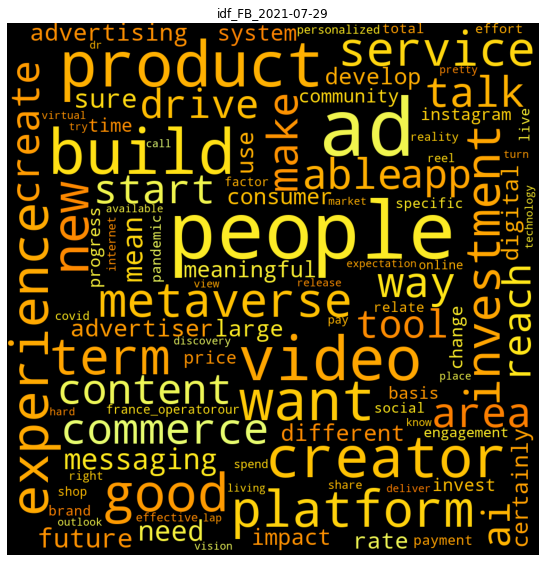

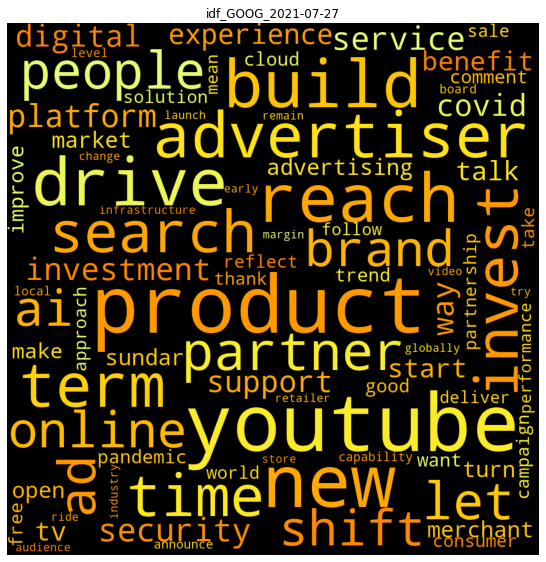

In [ ]:
tickers = df['ticker'].unique().tolist()
top_100_words = 100
wc = WordCloud(width = 1000, height = 1000,
               background_color = 'black',
               min_font_size = 20,
               max_font_size = 150,
               colormap='Wistia')
docs_joined = []
num_tickers = len(tickers)

for ticker in tickers:
    sub_df = df.loc[df['ticker']==ticker]
    sub_df = sub_df.sort_values('call_date', ascending=True)
    docs = sub_df['words_ngrams'].apply(lambda x: " ".join(x)).tolist()
    dates = sub_df['call_date'].tolist()
    num_dates = len(dates)

    #tokenize and build vocabulary
    idf_vector = tfidf_vectorizer.fit_transform(docs)
    index=0
    fig = plt.figure(figsize=(15,15))
    for dt, doc in zip(dates, docs):
        docs_joined.extend(doc)

        df_idf = pd.DataFrame(idf_vector[index].T.toarray(), index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
        dict_idf_topwords = df_idf.sort_values(by=['idf_weights'],ascending=False)[:top_100_words].to_dict()['idf_weights']

        plt.subplot(1*num_tickers, num_dates,index+1).set_title("idf_" + ticker + "_" + str(dt.date()))
        wc.generate_from_frequencies(dict_idf_topwords)
        # plot the WordCloud image                        
        plt.imshow(wc)
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        index += 1
plt.show()